In [1]:
#sys.path.insert(0, os.path.join(os.getcwd(), os.path.dirname(os.path.dirname(__file__)), 'module'))
import os
import sys
import logging
from zipfile import ZipFile
import tensorflow as tf
import bdlb
from tqdm import tqdm
import tensorflow_datasets as tfds

import torch
from torchvision import transforms
from PIL import Image
import numpy as np

data = tfds.load(name='cityscapes', split='train')
                 #data_dir='/cluster/work/riner/users/blumh/tensorflow_datasets')

In [2]:
label_lookup = tf.constant(
    [-1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, 2, 3, 4, -1, -1, -1, 5, -1, 6, 7, 8, 9,
     10, 11, 12, 13, 14, 15, -1, -1, 16, 17, 18])
def label_lookup_map(batch):
    batch['segmentation_label'] = tf.gather_nd(
        label_lookup,
        tf.cast(batch['segmentation_label'], tf.int32))
    return batch
data = data.map(label_lookup_map)



In [3]:
ret0 = np.zeros( (25))
for batch in tqdm(data, ascii=True):
    seg_labels = tf.reshape(batch['segmentation_label'], [-1])
    labels = np.unique(seg_labels.numpy(), return_counts = True)
    ret0[labels[0]] += labels[1]

2975it [01:53, 26.13it/s]


In [12]:
from collections import namedtuple
import numpy as np

# Based on https://github.com/mcordts/cityscapesScripts
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                 'has_instances', 'ignore_in_eval', 'color'])
classes = [
    CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    #CityscapesClass('license plate',        250, 255, 'vehicle', 7, False, True, (0, 0, 0)),
]
train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color.append([0, 0, 0])
train_id_to_color = np.array(train_id_to_color)
    
def decode_target(mask):
    """decode semantic mask to RGB image"""
    return train_id_to_color[mask]


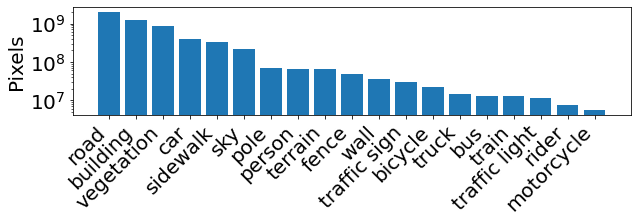

In [27]:
names = [x.name for x in classes if x.train_id!=255]

orders = dict(zip(names, list(ret0[:19])))
sort_orders = sorted(orders.items(), key=lambda x: x[1], reverse=True)



names_data = [x[0] for x in sort_orders]
ret = [x[1] for x in sort_orders]

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(19)
years = names_data
values = ret

plt.figure(figsize=(10,2))
plt.yscale("log")
plt.bar(x, values)
plt.xticks(x, years)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Pixels', fontsize=20)
plt.show()

In [6]:
sort_orders

[('road', 2036416525.0),
 ('building', 1260636120.0),
 ('vegetation', 879783988.0),
 ('car', 386328286.0),
 ('sidewalk', 336090793.0),
 ('sky', 221979646.0),
 ('pole', 67789506.0),
 ('person', 67326424.0),
 ('terrain', 63949536.0),
 ('fence', 48454166.0),
 ('wall', 36199498.0),
 ('traffic sign', 30448193.0),
 ('bicycle', 22861233.0),
 ('truck', 14772328.0),
 ('bus', 12990290.0),
 ('train', 12863955.0),
 ('traffic light', 11477088.0),
 ('rider', 7463162.0),
 ('motorcycle', 5449152.0)]

In [7]:
conv_dict = {0: 0,
 1: 3,
 2: 1,
 3: 9,
 4: 7,
 5: 4,
 6: 17,
 7: 11,
 8: 2,
 9: 10,
 10: 6,
 11: 8,
 12: 16,
 13: 5,
 14: 13,
 15: 15,
 16: 14,
 17: 18,
 18: 12}

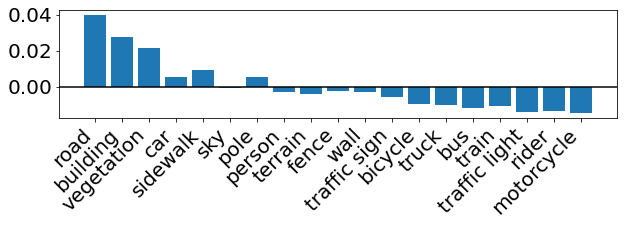

In [36]:
weight_max=[ 0.0400,  0.0094,  0.0274, -0.0031, -0.0023,  0.0053, -0.0141, -0.0057,
         0.0214, -0.0043, -0.0007, -0.0029, -0.0133,  0.0053, -0.0102, -0.0118,
        -0.0107, -0.0149, -0.0098]

names = [x.name for x in classes if x.train_id!=255]

val = zip(list(weight_max[:19]), list(ret0[:19]))
orders = dict(zip(names, val))
sort_orders = sorted(orders.items(), key=lambda x: x[1][1], reverse=True)

names = [x[0] for x in sort_orders]
ret = [x[1][0] for x in sort_orders]

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(19)
years = names
values = ret

plt.figure(figsize=(10,2))
plt.bar(x, values)
plt.xticks(x, years)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.ylabel('Value', fontsize=20)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

plt.show()

In [9]:
logit_mean={0: 3.7822632789611816, 1: 0.5979011654853821, 2: 1.474570631980896, 3: -0.1670774668455124, 4: -0.10103379935026169, 5: 0.1266193836927414, 6: -0.9868083000183105, 7: -0.4819525480270386, 8: 1.4335440397262573, 9: -0.11535324901342392, 10: -0.24086645245552063, 11: -0.5406373739242554, 12: -1.118493676185608, 13: 0.44269031286239624, 14: -0.6385785937309265, 15: -0.5933366417884827, 16: -0.7287777662277222, 17: -1.119286060333252, 18: -0.7492228746414185}
logit_mean = [logit_mean[x] for x in list(logit_mean)]

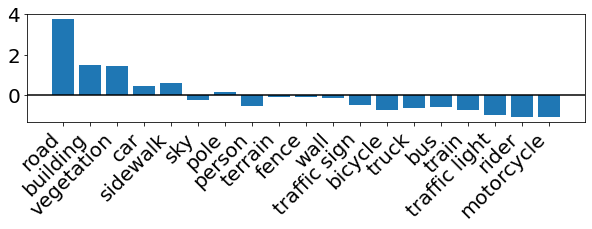

In [35]:
names = [x.name for x in classes if x.train_id!=255]

val = zip(list(logit_mean[:19]), list(ret0[:19]))
orders = dict(zip(names, val))
sort_orders = sorted(orders.items(), key=lambda x: x[1][1], reverse=True)

names = [x[0] for x in sort_orders]
ret = [x[1][0] for x in sort_orders]

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(19)
years = names
values = ret

plt.figure(figsize=(10,2))
plt.bar(x, values)
plt.xticks(x, years)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.ylabel('Value', fontsize=20)
#linestyles='-
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

plt.show()